In [1]:
#import the library of tensorflow ,Keras,opencv,numpy,pyplot
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    

tf.config.list_physical_devices('GPU')

[]

In [3]:
# load the Data
Data= tf.keras.utils.image_dataset_from_directory('Data')

Found 4397 files belonging to 2 classes.


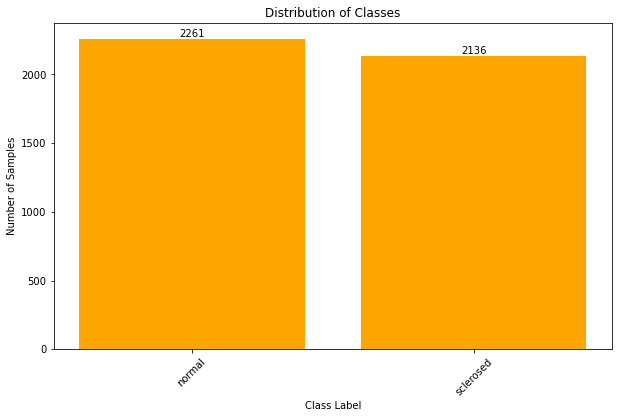

In [4]:
# Get the class names
class_names = Data.class_names

# Get the class labels from the training data generator
class_labels = np.concatenate([y for _, y in Data], axis=0)

# Count the occurrences of each class label
class_counts = np.bincount(class_labels)

# Plot the distribution of classes using a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_counts, color='orange')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Annotate each bar with its count
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{count}', ha='center', va='bottom')

plt.show()



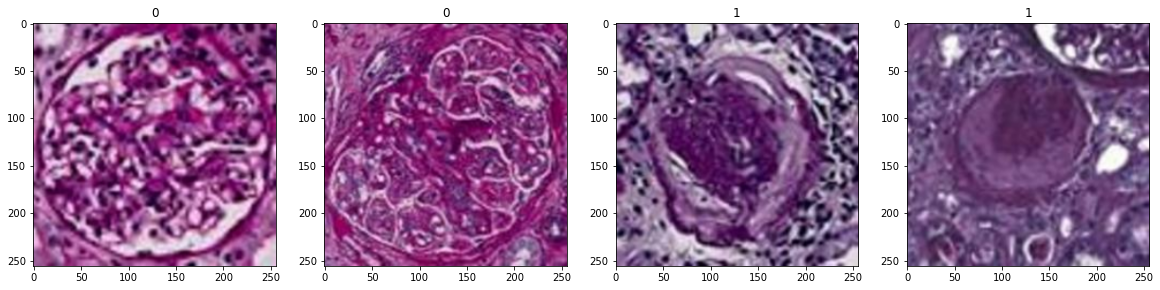

In [5]:
data_iterator = Data.as_numpy_iterator()
batch = data_iterator.next()
ig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
batch[0].shape

(32, 256, 256, 3)

In [7]:
scaled = batch[0]/255
scaled.max()

1.0

In [8]:
# preprocess the data
# scale data
data = Data.map(lambda x,y: (x/255, y))


In [9]:
# Split data into training, validation, and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

# Split the data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


In [10]:
# Load the pre-trained VGG16 model without the fully connected layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional layers so they're not trainable
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom fully connected layers on top of VGG16
x = Flatten()(vgg_base.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # num_classes is the number of output classes

# Create the model
model = Model(inputs=vgg_base.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define ModelCheckpoint callback to save the best model weights during training
checkpoint = ModelCheckpoint("best_model.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

# Define EarlyStopping callback to stop training if the validation loss does not improve after a certain number of epochs
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

In [12]:
# Train the model
history = model.fit(
      train,
      epochs=10, 
      validation_data=val,
      callbacks=[checkpoint, early_stopping])


Epoch 1/10


96/96 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.8981
Epoch 1: val_accuracy improved from -inf to 0.97801, saving model to best_model.h5
96/96 [==============================] - 795s 8s/step - loss: 0.6900 - accuracy: 0.8981 - val_loss: 0.0504 - val_accuracy: 0.9780
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9860
Epoch 2: val_accuracy improved from 0.97801 to 0.98958, saving model to best_model.h5
96/96 [==============================] - 826s 9s/step - loss: 0.0424 - accuracy: 0.9860 - val_loss: 0.0291 - val_accuracy: 0.9896
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9909
Epoch 3: val_accuracy improved from 0.98958 to 0.99074, saving model to best_model.h5
96/96 [==============================] - 838s 9s/step - loss: 0.0246 - accuracy: 0.9909 - val_loss: 0.0270 - val_accuracy: 0.9907
Epoch 4/10
96/96 [==============================] - ETA: 0s - loss: 0.0199 - accurac

In [13]:
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained model
model.save('ckd.h5')


In [14]:
# Load the saved model
model = load_model("ckd.h5")


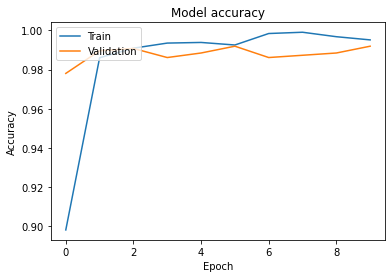

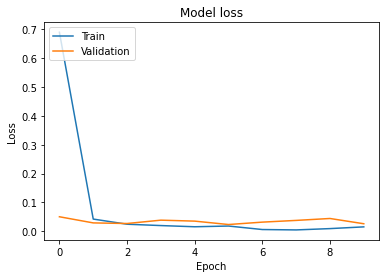

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


15/15 [==============================] - 79s 5s/step


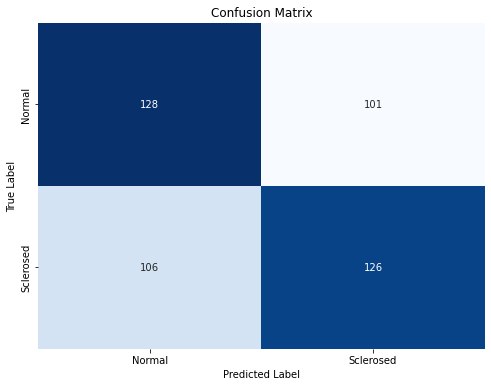

In [22]:
# Make predictions on the test set
y_pred = model.predict(test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Manually specify class names
class_names = ['Normal', 'Sclerosed']
y_true = np.concatenate([y for x, y in test], axis=0)


# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [23]:
# Calculate TP, FP, TN, FN
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Calculate Positive Predictive Value (PPV) or Precision
PPV = TP / (TP + FP)

# Calculate Negative Predictive Value (NPV)
NPV = TN / (TN + FN)

# Calculate Specificity
Specificity = TN / (TN + FP)

# Calculate Sensitivity (Recall)
Sensitivity = TP / (TP + FN)

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)
print("Positive Predictive Value (PPV):", PPV)
print("Negative Predictive Value (NPV):", NPV)
print("Specificity:", Specificity)
print("Sensitivity (Recall):", Sensitivity)


True Positives (TP): 126
False Positives (FP): 101
True Negatives (TN): 128
False Negatives (FN): 106
Positive Predictive Value (PPV): 0.5550660792951542
Negative Predictive Value (NPV): 0.5470085470085471
Specificity: 0.5589519650655022
Sensitivity (Recall): 0.5431034482758621


In [24]:
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("Accuracy:", accuracy)


Accuracy: 0.5509761388286334


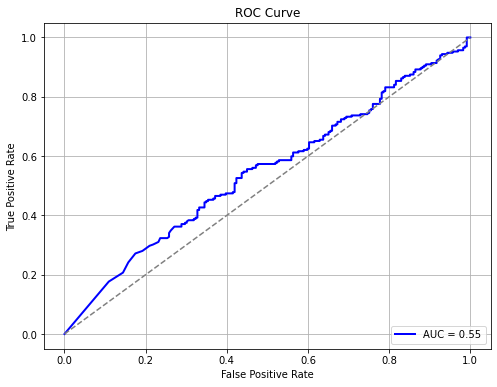

: 

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC score
auc_score = roc_auc_score(y_true, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
